## Seedlings super-charged!

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

PATH = "data/seedlings/"
sz=100
arch=resnext50
bs=16
CSV_PATH = f'{PATH}labels.csv'

### Create Validation Set (from CSV)

In [26]:
from glob import glob
import pandas as pd

df = pd.DataFrame(columns=["file", "species"])

for image in glob(f'{PATH}train_orig/**/*.png'):
# for image in glob(f'{PATH}train/**/*.png'):
    dir_ = image.split('/')
    file_, species = dir_[-1], dir_[-2]

    df = df.append({
        "file": file_,
        "species": species.replace(" ", "_")
        }, ignore_index=True)

In [27]:
df.to_csv(CSV_PATH, index=False)

In [ ]:
# Bash command to move all images in training folder out of their category sub directories
# cd data/train
# find ./ -type f -print0 | xargs -0 mv -t ./

# then remove empty subdirectories
# https://unix.stackexchange.com/questions/68846/how-do-i-remove-all-sub-directories-from-within-a-directory

In [25]:
df.head()

,file,species
0,0bec204c7.png,Cleavers
1,d8597aa6a.png,Cleavers
2,7e8212b65.png,Cleavers
3,58b68b1ea.png,Cleavers
4,ef4a36963.png,Cleavers


### Setup model

In [39]:
df = pd.read_csv(CSV_PATH)

In [40]:
n = df.shape[0]-1
val_idxs = get_cv_idxs(n)

def get_data(sz,bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    data = ImageClassifierData.from_csv(path=PATH, folder='train', csv_fname=CSV_PATH, num_workers=4, #suffix='.png', 
                                        tfms=tfms, test_name='test', val_idxs=val_idxs, skip_header=True, bs=bs)
#     return data.resize(sz, 'tmp') # for some reason this crashes
    return data

In [41]:
arch = resnet50
data = get_data(sz, bs)

In [42]:
# tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
# data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4, test_name='test')
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

### Let's look at the learning rate finder

In [43]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 72%|███████▏  | 172/238 [00:02<00:00, 82.07it/s, loss=9.6] 


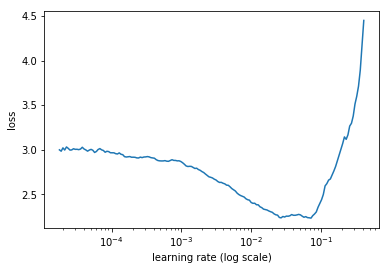

In [44]:
learn.sched.plot()

### Start training

In [45]:
learn.fit(1e-2, 1)
learn.precompute=False

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      1.613024   1.182681   0.606458  



In [46]:
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.379293   0.984033   0.672083  
    1      1.293766   0.945786   0.682708                   
    2      1.247229   0.914352   0.692917                   
    3      1.241133   0.903095   0.695208                   



[0.9030948, 0.6952083334326744]

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 79%|███████▉  | 189/238 [00:12<00:03, 14.56it/s, loss=4.86]

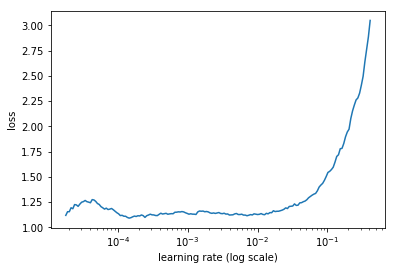

In [47]:
lrf=learn.lr_find()
learn.sched.plot()

In [48]:
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])

In [49]:
learn.fit(lr, 5, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=31), HTML(value='')))

 45%|████▌     | 108/238 [00:09<00:10, 11.88it/s, loss=1.24]

Exception in thread Thread-34:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      0.760909   0.415559   0.869792  
    1      0.598122   0.316068   0.88                        
    2      0.46076    0.251797   0.910417                    
    3      0.497481   0.263917   0.905208                    
    4      0.349051   0.217801   0.914167                    
    5      0.346931   0.193906   0.924583                    
    6      0.260666   0.18452    0.93125                     
    7      0.379361   0.226611   0.926042                    
    8      0.324751   0.180784   0.93125                     
    9      0.29894    0.164487   0.945833                    
    10     0.245367   0.174615   0.934375                    
    11     0.210026   0.15363    0.951042                    
    12     0.162734   0.138137   0.95                        
    13     0.161875   0.137534   0.954167                    
    14     0.154817   0.141346   0.955208                    
    15     0.243028   0.17

[0.14074059, 0.959375]

In [50]:
learn.save('100_first')

In [ ]:
learn.precompute=False
learn.unfreeze()

In [51]:
learn.load('100_first')

In [65]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

accuracy_np(probs,y)

0.964172813487882

In [66]:
print(probs[:4])
print(y[:4])

[[0.      0.      0.00001 0.      0.      0.00001 0.      0.00001 0.00002 0.      0.      0.99996]
 [0.      0.      0.      0.      0.00002 0.00055 0.      0.00024 0.      0.      0.00005 0.99913]
 [0.00004 0.0018  0.68536 0.00021 0.00012 0.26421 0.00005 0.0001  0.00001 0.0002  0.04781 0.0001 ]
 [0.      0.00003 0.00025 0.99908 0.      0.00001 0.      0.00028 0.00016 0.00011 0.00002 0.00005]]
[11 11  2  3]


## Analyzing results

In [60]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[ 33   0   0   0   0   0  11   0   0   0   0   0]
 [  0  93   1   0   0   0   0   0   0   0   0   0]
 [  0   0  46   0   0   1   0   0   0   0   0   1]
 [  0   0   0 128   0   0   0   0   1   0   0   0]
 [  1   0   0   0  36   0   0   1   0   0   0   0]
 [  0   0   0   0   1  95   0   0   0   0   0   0]
 [  9   0   0   0   0   0 131   0   0   0   0   0]
 [  0   0   0   0   0   0   0  54   0   0   0   0]
 [  0   0   0   1   0   0   1   0  92   0   0   0]
 [  0   0   0   0   0   0   0   0   1  47   0   0]
 [  0   0   0   0   0   0   2   0   0   0  91   0]
 [  0   0   0   1   0   0   0   0   1   0   0  69]]


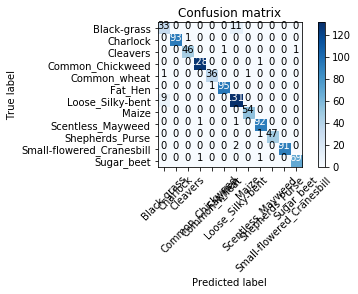

In [61]:
plot_confusion_matrix(cm, data.classes)

In [62]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

Most incorrect cats


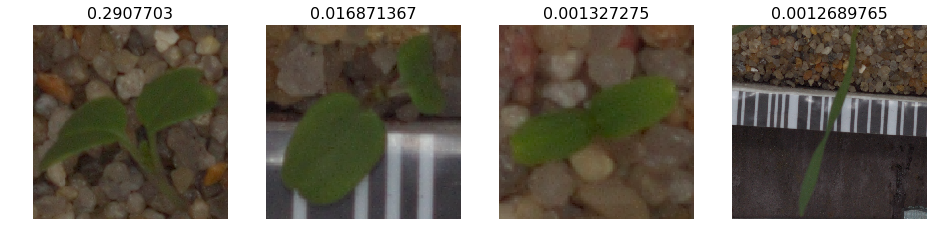

In [63]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


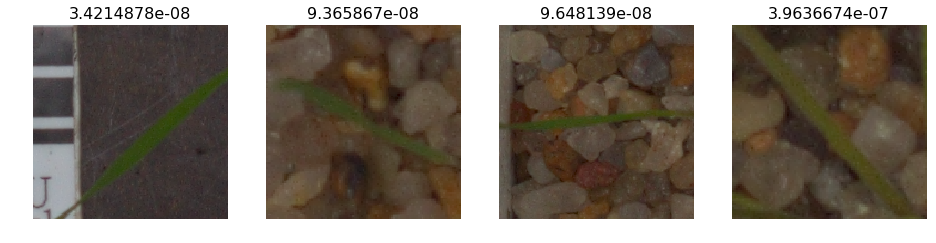

In [64]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

### Let's train a little bit more

In [ ]:
learn.precompute=False
learn.unfreeze()

In [70]:
learn.load('100_first')

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 45%|████▍     | 107/238 [00:08<00:10, 12.45it/s, loss=0.157] 


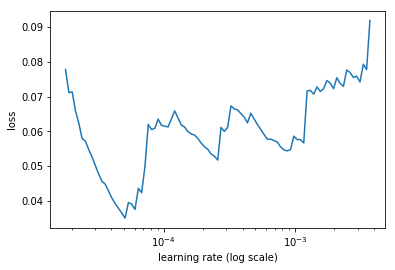

In [67]:
lrf=learn.lr_find()
learn.sched.plot()

In [71]:
lr=np.array([1e-6,1e-5,1e-4])

In [72]:
learn.fit(lr, 5, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=31), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.071734   0.139973   0.958333  
    1      0.067987   0.141332   0.957292                     
 66%|██████▋   | 158/238 [00:12<00:06, 12.47it/s, loss=0.0637]

KeyboardInterrupt: 

### Submission

In [73]:
log_preds,y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds),0)

In [74]:
probs.shape

(794, 12)

In [75]:
ds = pd.DataFrame(probs)
ds.columns = data.classes

In [76]:
ds.head()

,Black-grass,Charlock,Cleavers,Common_Chickweed,Common_wheat,Fat_Hen,Loose_Silky-bent,Maize,Scentless_Mayweed,Shepherds_Purse,Small-flowered_Cranesbill,Sugar_beet
0,4.966334e-03,6.158595e-05,3.257852e-04,4.342386e-05,9.924759e-01,1.097239e-03,2.354374e-04,0.000229,2.998661e-04,7.912089e-07,1.759714e-06,0.000263
1,8.538042e-08,2.673209e-07,5.944213e-06,1.218154e-06,8.565488e-07,1.493072e-06,1.355753e-07,0.000005,1.392661e-05,7.757916e-05,9.998730e-01,0.000020
2,1.813026e-06,2.655530e-06,1.212991e-06,8.638284e-07,2.327183e-06,3.229696e-07,4.339888e-07,0.000001,1.348423e-05,1.469447e-04,9.998258e-01,0.000003
3,7.786079e-09,6.465664e-08,6.277135e-09,4.019467e-08,1.213795e-07,8.676720e-08,1.085457e-08,0.999991,4.736703e-09,3.600559e-09,2.229899e-07,0.000009
4,2.249489e-07,9.807364e-07,2.652855e-05,2.331848e-07,5.130677e-06,7.174946e-06,9.663997e-08,0.000009,9.960901e-06,1.441463e-05,9.998655e-01,0.000060


In [ ]:
ds.insert(0, 'name', [o[len('test/'):-len('.jpg')] for o in data.test_ds.fnames])
ds.drop(columns='0.0', axis=1, inplace=True)
ds.rename(columns={'1.0':'invasive'}, inplace=True)

In [ ]:
ds.head()

In [ ]:
SUBM_FOLDER = f'{PATH}subm/'
SUBM_FILE = f'{SUBM_FOLDER}subm_all.gz'
os.makedirs(SUBM_FOLDER, exist_ok=True)
ds.to_csv(SUBM_FILE, compression='gzip', index=False)

In [ ]:
test_csv_path = PATH+'test_labels.csv'
ds.to_csv(test_csv_path, index=False)

In [ ]:
FileLink(SUBM_FILE)

In [ ]:
ds_clipped = ds.copy()
ds_clipped['invasive'] = ds_clipped.invasive.clip(lower=0.01, upper=0.99)

In [ ]:
ds_clipped.shape

In [ ]:
SUBM_FILE_CLIPPED = f'{SUBM_FOLDER}subm_all_clipped.gz'
os.makedirs(SUBM_FOLDER, exist_ok=True)
ds_clipped.to_csv(SUBM_FILE_CLIPPED, compression='gzip', index=False)

In [ ]:
FileLink(SUBM_FILE_CLIPPED)

## Combining test data predictions and running model again

In [ ]:
df_test = pd.read_csv(test_csv_path)
df_train = pd.read_csv(train_csv_path)

In [ ]:
df_test.head()

In [ ]:
df_test['invasive'] = df_test.invasive.round()

In [ ]:
df_test.name = df_test.name.apply(lambda x: 'test-'+str(x), convert_dtype=True)

In [ ]:
df_all = pd.concat([df_test, df_train])
print(df_all.shape)
print(df_test.shape)
print(df_train.shape)

In [ ]:
all_csv_path = PATH+'all_labels.csv'
df_all.to_csv(all_csv_path, index=False)

### Move images to all

In [ ]:
%mkdir "{PATH}all"

In [ ]:
%cp "{PATH}train/"* "{PATH}all"

In [ ]:
# Append "test-" suffix to test images and move to all folder
import shutil
import os

_, _, filenames = next(os.walk(f'{PATH}test'))
for f in filenames:
#     print(f'{PATH}test/{f}')
#     print(f'{PATH}all/test-{f}')
    shutil.copyfile(f'{PATH}test/{f}', f'{PATH}all/test-{f}')

### Checking dimensions

In [ ]:
print(df_all.shape)
_, _, filenames = next(os.walk(f'{PATH}all'))
print(len(filenames))

### Running data on new frame

In [ ]:
# Uncomment the below if you need to reset your precomputed activations
# !rm -rf {PATH}tmp

In [ ]:
all_csv_path = PATH+'all_labels.csv'
df_all = pd.read_csv(all_csv_path)

In [ ]:
n = df_all.shape[0]-1
val_idxs = get_cv_idxs(n, val_pct=.1)
# sz = 520
arch = resnet50
def get_all_data(sz,bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(path=PATH, folder='all', csv_fname=all_csv_path, num_workers=4, 
                                        tfms=tfms, suffix='.jpg', test_name='test', val_idxs=val_idxs, skip_header=True, bs=bs)
    return data.resize(sz, 'tmp')

In [ ]:
data = get_all_data(sz, bs)


In [45]:
learn.fit(1e-2, 1)
learn.precompute=False

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      1.613024   1.182681   0.606458  



In [46]:
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.379293   0.984033   0.672083  
    1      1.293766   0.945786   0.682708                   
    2      1.247229   0.914352   0.692917                   
    3      1.241133   0.903095   0.695208                   



[0.9030948, 0.6952083334326744]

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 79%|███████▉  | 189/238 [00:12<00:03, 14.56it/s, loss=4.86]

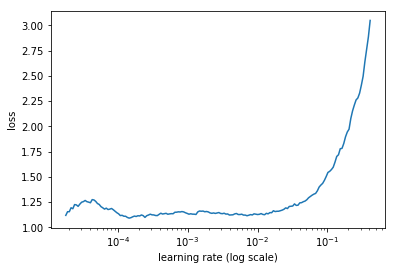

In [47]:
lrf=learn.lr_find()
learn.sched.plot()

In [48]:
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])

In [ ]:
learn.fit(lr, 5, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=31), HTML(value='')))

 45%|████▌     | 108/238 [00:09<00:10, 11.88it/s, loss=1.24]

Exception in thread Thread-34:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      0.760909   0.415559   0.869792  
    1      0.598122   0.316068   0.88                        
    2      0.46076    0.251797   0.910417                    
    3      0.497481   0.263917   0.905208                    
    4      0.349051   0.217801   0.914167                    
    5      0.346931   0.193906   0.924583                    
    6      0.260666   0.18452    0.93125                     
    7      0.379361   0.226611   0.926042                    
    8      0.324751   0.180784   0.93125                     
    9      0.29894    0.164487   0.945833                    
    10     0.245367   0.174615   0.934375                    
    11     0.210026   0.15363    0.951042                    
    12     0.162734   0.138137   0.95                        
    13     0.161875   0.137534   0.954167                    
    14     0.154817   0.141346   0.955208                    
    15     0.243028   0.17

In [36]:
learn.save('100_first')

In [37]:
learn.load('100_first')

### Submission

In [ ]:
log_preds,y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds),0)

In [ ]:
probs.shape

In [ ]:
ds = pd.DataFrame(probs)
ds.columns = data.classes

In [ ]:
ds.head()

In [ ]:
ds.insert(0, 'name', [o[len('test/'):-len('.jpg')] for o in data.test_ds.fnames])
ds.drop(columns='0.0', axis=1, inplace=True)
ds.rename(columns={'1.0':'invasive'}, inplace=True)

In [ ]:
ds.head()

In [ ]:
SUBM_FOLDER = f'{PATH}subm/'
SUBM_FILE = f'{SUBM_FOLDER}subm_all.gz'
os.makedirs(SUBM_FOLDER, exist_ok=True)
ds.to_csv(SUBM_FILE, compression='gzip', index=False)

In [ ]:
test_csv_path = PATH+'test_labels.csv'
ds.to_csv(test_csv_path, index=False)

In [ ]:
FileLink(SUBM_FILE)

In [ ]:
ds_clipped = ds.copy()
ds_clipped['invasive'] = ds_clipped.invasive.clip(lower=0.01, upper=0.99)

In [ ]:
ds_clipped.shape

In [ ]:
SUBM_FILE_CLIPPED = f'{SUBM_FOLDER}subm_all_clipped.gz'
os.makedirs(SUBM_FOLDER, exist_ok=True)
ds_clipped.to_csv(SUBM_FILE_CLIPPED, compression='gzip', index=False)

In [ ]:
FileLink(SUBM_FILE_CLIPPED)

### Make sure to replace underscore with space on submission

In [ ]:
log_preds_test = np.argmax(log_preds_test, axis=1)
preds_classes = [data.classes[i].replace("_", " ") for i in log_preds_test]
probs = np.exp(log_preds_test)

submission = pd.DataFrame(preds_classes, os.listdir(f'{PATH}test'))